In [1]:
import numpy as np
import math
import keras
import time
from datetime import timedelta
import datetime
import pandas as pd
import random
from src import utils, trnvaltst, TGCNN_layer, whole_model, create_fake_patients, plot_figures
from early_stopping import EarlyStopping
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, roc_auc_score, recall_score
from csv import writer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
print("tensorflow version:", tf. __version__)
tf.config.list_physical_devices('CPU')

tensorflow version: 2.8.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [2]:
no_LSTM = False # True = without LSTM
no_exponential = True # True = without exponential
L1_ablation = True # True = with L1 reg
L2_ablation = True # True = with L2 reg
variable_gamma = False
graph_reg_incl = False

num_of_runs = 1

if no_exponential == True:
    exponential_scaling = False
else:
    exponential_scaling = True    
    
weighted_loss = False # class weighted to deal with imbalance if True
no_timestamp = False # if no_timestamp = True then all values in 3-tensor = 1
activation_type = 'gelu' #'relu','gelu', 'LeakyReLU'
second_TGCNN_layer = True

run_name='test_model' + activation_type 

# strings for hyperparameter searching file
LSTM_str="LSTM excluded" if no_LSTM == True else "LSTM included"
exp_str = "exp excluded" if no_exponential == False else "exp included"
timestamp_str = "time elapsed = 1" if no_timestamp == True else "time elapsed"
weighted_loss_str = "weighted_loss" if weighted_loss ==True else "unweighted_loss"
L1_str = "L1 included" if L1_ablation == True else "L1 excluded"
L2_str = "L2 included" if L2_ablation == True else "L2 excluded"
second_layer_str = "Branched model" if second_TGCNN_layer == True else "Unbranched model"

In [3]:
num_codes_to_use = 512
max_event_codes = 512
max_timesteps = 100
num_patients = 50000

# read in a pd df or pickle below
input_values_indices_df = create_fake_patients.create_fake_patient_df(num_patients=num_patients+1, max_events=200, max_nodes=10)

sample_size = len(input_values_indices_df)

# y = utils.load_in_y_visit_count(num_codes_to_use)

# create dictionary of 'labels'
y = create_fake_patients.create_fake_int_label(num_patients)

# count the number of occurrences of each value
num_in_cat_df = value_counts = y['int_label'].value_counts()
# create a dictionary to map the values to labels
value_dict = {0: 'Zero', 1: 'Low', 2: 'High'}
class_names = ['Zero', 'Low', 'High']

# create a new DataFrame with the value counts
df_value_counts = pd.DataFrame({'Value': value_counts.index, 'Count': value_counts.values})

# replace the values in the "Value" column with the corresponding labels
df_value_counts['Value'] = df_value_counts['Value'].map(value_dict)

# convert the DataFrame to a dictionary
num_in_cat_dict = df_value_counts.set_index('Value')['Count'].to_dict()

# some people will be removed due to having 5 or less historic data records (=<5 visits). 
# Also any people that whom all of their Read codes do not appear in the top 1000 codes


print(f"Number of people in the input data {len(input_values_indices_df)}")
#print(f"Number of people in label data: {y.shape[0]}")
y = y[:sample_size+1]
print(f"Number of people in label data: {y.shape[0]}")
low_norm, high_norm, zero_norm = utils.normalised_inv_class_proportion(num_in_cat_dict)
class_weights = tf.compat.v2.constant([[high_norm, low_norm, zero_norm]]) # this needs to be in the order of class occurence

Number of people in the input data 50000
Number of people in label data: 50000


In [4]:
y

,int_label
0,0
1,1
2,1
3,2
4,2
...,...
49995,1
49996,0
49997,1
49998,0


In [5]:
num_in_cat_dict

{'Zero': 16696, 'High': 16672, 'Low': 16632}

In [6]:
input_matrices = []


for patient in range(sample_size):
#for patient in range(10240):
    
    i_list = input_values_indices_df.iloc[patient]['indices'] # indices from patient cell
    #print(len(i_list))
    v_list = input_values_indices_df.iloc[patient]['values'] # values from patient cell
    #print(len(v_list))
    
    individual_sparse = tf.sparse.SparseTensor(i_list, v_list, (max_event_codes, max_event_codes, max_timesteps))
    #print(individual_sparse)
    
    # adding the sparse tensor to a list of all the tensors
    ordered_indiv = tf.sparse.reorder(individual_sparse) # reorder required for tensor to work (no effect to outcome)
    input_matrices.append(tf.sparse.expand_dims(ordered_indiv, axis=0))
    #print(input_matrices)
    
    if patient%10000 == 0:
        print(f"{patient}/{sample_size} converted to SparseTensors {patient/sample_size:.2%}")
    #break

0/50000 converted to SparseTensors 0.00%
10000/50000 converted to SparseTensors 20.00%
20000/50000 converted to SparseTensors 40.00%
30000/50000 converted to SparseTensors 60.00%
40000/50000 converted to SparseTensors 80.00%


### Data splitting

In [7]:
# for cross validation the data could be split into 5 folds each which make up 20% of the data
# but for now just split into train, validation and test
train_perc = 0.7
val_perc = 0.15
test_perc = 0.15

train_size = int(round(sample_size*train_perc))
val_size = int(round(sample_size*val_perc))
test_size = int(round(sample_size*test_perc))

### Save metrics

In [8]:
# save the average epoch to the list of all epochs
def metric_save(trn_epoch_metric, trn_all_epoch_avgs, 
            val_epoch_metric, val_all_epoch_avgs,
            test_epoch_metric, test_all_epoch_avgs):
    trn_all_epoch_avgs.append(trn_epoch_metric)
    val_all_epoch_avgs.append(val_epoch_metric)
    test_all_epoch_avgs.append(test_epoch_metric)

# Loop for hyperparameter tuning starts here!

### Repeated Hyperparameter Selection - not random search

In [9]:
    ############################# Repeated Hyperparameter Selection #############################
#     nepochs = 20
#     lr = 1e-2 #initial learning rate
#     out_chans = 1 # number of filters
#     filter_size = 3 # number of time steps/ filter size
#     if no_LSTM:
#         lstm_h = 0
#     else:
#         lstm_h = 128 # number of LSTM neurons
    
#     reg_strength = 1e-1#1e3
#     linear_size = 512 # linear layer output size
#     drop_val = 0.5
    ############################################################################################

### Random Hyperparameter Selection

Run name: test_modelgelu 0
Number of epochs: 2
Learning rate: 0.05
Number of 3D CNN filters: 32
Filter size: 3
Number of LSTM neurons: 16
Number of fully connected layers: 64
Dropout value: 0.6
Regularisation strength: 0.01
Number of epochs: 2
****************************************

Epoch 1/2

TRAINING METRICS:
Train loss 3269.1050
Train accuracy: 33.1030%

VALIDATION METRICS:
Validation loss: 2059.0913
Validation accuracy: 33.3603%

TEST METRICS:
Test loss: 2059.0891
Test accuracy: 33.2000%
Validation loss decreased (inf --> 2059.091309).

Epoch 2/2

TRAINING METRICS:
Train loss 1722.7930
Train accuracy: 33.1601%

VALIDATION METRICS:
Validation loss: 1620.4069
Validation accuracy: 33.2799%

TEST METRICS:
Test loss: 1620.4045
Test accuracy: 33.1868%
Validation loss decreased (2059.091309 --> 1620.406860).


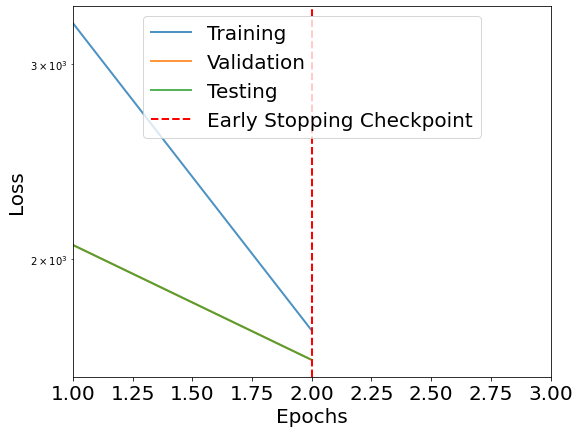

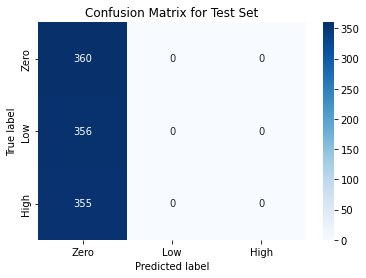

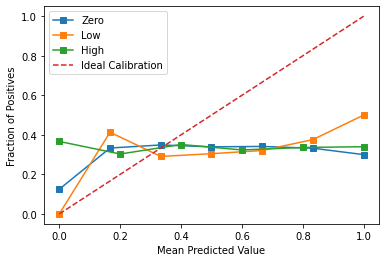

In [11]:
for ran_search_num in range(num_of_runs):
    #random.seed(time.time())
    print('Run name:', run_name, ran_search_num)
    indices = list(range(len(input_matrices)))
    random.shuffle(indices) # shuffles datasets
    train_set_indices = indices[:train_size]
    val_set_indices = indices[train_size:train_size+val_size]
    test_set_indices = indices[-test_size:]

    train_batch_size = 1024
    val_batch_size = 1024
    test_batch_size = 1024
#     print("y is")
#     print(y)
#     print(type(y))
#     print(type(train_set_indices))
#     print(y.values.tolist())
    batched_graphs_trn, batched_labels_trn = utils.batch_set(indice_set=train_set_indices, input_matrices=input_matrices, 
                                                       labels=y.to_numpy(), batchsize=train_batch_size)                                           
    batched_graphs_val, batched_labels_val = utils.batch_set(indice_set=val_set_indices, input_matrices=input_matrices, 
                                                       labels=y.to_numpy(), batchsize=val_batch_size)
    batched_graphs_test, batched_labels_test = utils.batch_set(indice_set=test_set_indices, input_matrices=input_matrices, 
                                                         labels=y.to_numpy(), batchsize=test_batch_size)
    

    #nepochs = random.choice([25, 50, 75, 100])
    nepochs=2 #200
    lr = random.choice([0.01, 0.05, 0.001, 0.005, 0.0001]) # initial learning rate

    out_chans = random.choice([8, 16, 32]) # number of filters
    filter_size = random.choice([3, 4, 6]) # number of time steps/ filter size
    if no_LSTM:
        lstm_h = 0
    else:
        lstm_h = random.choice([16, 32, 64, 128, 256]) # number of LSTM neurons
    linear_size = random.choice([64, 128]) # linear layer output size
    #drop_val = random.choice([0.2, 0.3, 0.4, 0.5])
    drop_val = random.choice([0.5, 0.6, 0.7, 0.8, 0.9])
    reg_strength = random.choice([1e-2, 5e-2, 1e-3, 5e-3, 1e-4, 5e-4, 1e-5])
    #reg_strength = random.choice([100, 10, 1, 1e-1, 5e-1])
    graph_reg_strength = 1e1
    


    print(f"Number of epochs: {nepochs}")
    print(f"Learning rate: {lr}")
    print(f"Number of 3D CNN filters: {out_chans}")
    print(f"Filter size: {filter_size}")
    print(f"Number of LSTM neurons: {lstm_h}")
    print(f"Number of fully connected layers: {linear_size}")
    print(f"Dropout value: {drop_val}")
    print(f"Regularisation strength: {reg_strength}")
    print(f"Number of epochs: {nepochs}")
    print("*"*40)
    model = whole_model.TGCNN_Model(num_filters=out_chans, num_nodes=max_event_codes, num_time_steps=max_timesteps, 
                        filter_size=filter_size, variable_gamma=variable_gamma, 
                        exponential_scaling=exponential_scaling, dropout_rate=drop_val, lstm_units=lstm_h,
                       fcl1_units=linear_size, LSTM_ablation=no_LSTM, stride=1, activation_type=activation_type, 
                        no_timestamp=no_timestamp, second_TGCNN_layer=second_TGCNN_layer)
    early_stopping = EarlyStopping(patience=5, verbose=True)


    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=10000,
        decay_rate=0.9)

    #cce_loss_fn = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    start_time = time.monotonic()

    epochs = nepochs
    train_loss_epochs, train_acc_epochs, train_prec_epochs, train_recall_epochs, train_f1_epochs, train_auc_epochs = [],[],[],[],[],[]
    train_indiv_acc_epochs, train_indiv_prec_epochs, train_indiv_recall_epochs, train_indiv_f1_epochs, train_indiv_auc_epochs = [],[],[],[],[]
    val_loss_epochs, val_acc_epochs, val_prec_epochs, val_recall_epochs, val_f1_epochs, val_auc_epochs = [],[],[],[],[],[]
    val_indiv_acc_epochs, val_indiv_prec_epochs, val_indiv_recall_epochs, val_indiv_f1_epochs, val_indiv_auc_epochs = [],[],[],[],[]
    test_loss_epochs, test_acc_epochs, test_prec_epochs, test_recall_epochs, test_f1_epochs, test_auc_epochs = [],[],[],[],[],[]
    test_indiv_acc_epochs, test_indiv_prec_epochs, test_indiv_recall_epochs, test_indiv_f1_epochs, test_indiv_auc_epochs = [],[],[],[],[]
    for epoch in range(epochs):
        #if epoch % 10 == 0:
        print(f"\nEpoch {epoch+1}/{nepochs}")

        # Iterate over the batches of the dataset.
        train_loss_list, train_acc_list, train_prec_list, train_recall_list, train_f1_list, train_auc_list = [],[],[],[],[],[]
        #train_all_classes_acc_list, 
        train_all_classes_prec_list, train_all_classes_recall_list, train_all_classes_f1_list, train_all_classes_auc_list = [],[],[],[] # lists of lists
        
        for step, (x_batch_train, y_batch_train) in enumerate(zip(batched_graphs_trn, batched_labels_trn)):
            y_batch_train=np.array(y_batch_train)
            trn_logits, trn_loss, trn_acc, trn_prec, trn_recall, trn_auc, trn_f1, \
            indiv_trn_prec, indiv_trn_recall, indiv_trn_auc, indiv_trn_f1, \
            = trnvaltst.train_step(x_batch_train,y_batch_train,reg_strength,class_weights,model,L1_ablation,L2_ablation, 
                                   graph_reg_strength, graph_reg_incl,
                                   weighted_loss, variable_gamma, optimizer)
            
            train_loss_list.append(trn_loss)
            train_acc_list.append(trn_acc)
        
            train_all_classes_prec_list.append(trn_prec)
            train_prec_list.append(indiv_trn_prec)

            train_all_classes_recall_list.append(trn_recall)
            train_recall_list.append(indiv_trn_recall)
            
            train_all_classes_auc_list.append(trn_auc)
            train_auc_list.append(indiv_trn_auc)
            
            train_all_classes_f1_list.append(trn_f1)
            train_f1_list.append(indiv_trn_f1)

        
        # get the average metric score for each class for this ONE epoch using the batch list metrics
        #train_acc_indiv_ave = utils.average_of_list_of_lists(train_all_classes_acc_list) # average accuracy score for each class over one epoch
        train_prec_indiv_ave = utils.average_of_list_of_lists(train_all_classes_prec_list)
        train_recall_indiv_ave = utils.average_of_list_of_lists(train_all_classes_recall_list)
        train_f1_indiv_ave = utils.average_of_list_of_lists(train_all_classes_f1_list) # ave F1 score for each class
        train_auc_indiv_ave = utils.average_of_list_of_lists(train_all_classes_auc_list)
        
        print("\nTRAINING METRICS:")
#         print(f"Training individual precision scores: {train_prec_indiv_ave}")
#         print(f"Training individual recall scores: {train_recall_indiv_ave}") # true positive rate
#         print(f"Training individual F1 scores: {train_f1_indiv_ave}")
#         print(f"Training individual AUC scores: {train_auc_indiv_ave}")
        print(f"Train loss {np.mean(train_loss_list):.4f}")
        print(f"Train accuracy: {np.mean(train_acc_list) :.4%}")
        
 
    

        # Validation loop
        val_loss_list, val_acc_list,  val_prec_list, val_recall_list, val_auc_list, val_f1_list = [],[],[],[],[],[]
        val_all_classes_acc_list, val_all_classes_prec_list, val_all_classes_recall_list, val_all_classes_f1_list, val_all_classes_auc_list = [],[],[],[],[]
        for x_batch_val, y_batch_val in zip(batched_graphs_val, batched_labels_val):
            val_logits, val_loss, val_acc, val_prec, val_recall, val_auc, val_f1, \
            indiv_val_prec, indiv_val_recall, indiv_val_auc, indiv_val_f1, \
            = trnvaltst.val_step(x_batch_val,y_batch_val,reg_strength,class_weights,model,L1_ablation,weighted_loss)

            val_loss_list.append(val_loss)
            
            val_acc_list.append(val_acc)
            
            val_prec_list.append(val_prec)
            val_all_classes_prec_list.append(indiv_val_prec)
            
            val_recall_list.append(val_recall) 
            val_all_classes_recall_list.append(indiv_val_recall)
            
            val_auc_list.append(val_auc)
            val_all_classes_auc_list.append(indiv_val_auc)
            
            val_f1_list.append(val_f1)
            val_all_classes_f1_list.append(indiv_val_f1)
            
        val_prec_indiv_ave = utils.average_of_list_of_lists(val_all_classes_prec_list)
        val_recall_indiv_ave = utils.average_of_list_of_lists(val_all_classes_recall_list)
        val_f1_indiv_ave = utils.average_of_list_of_lists(val_all_classes_f1_list) # ave F1 score for each class
        val_auc_indiv_ave = utils.average_of_list_of_lists(val_all_classes_auc_list)

        print("\nVALIDATION METRICS:")
#         print(f"Validation individual precision scores: {val_prec_indiv_ave}")
#         print(f"Validation individual recall scores: {val_recall_indiv_ave}") # true positive rate
#         print(f"Validation individual F1 scores: {val_f1_indiv_ave}")
#         print(f"Validation individual AUC scores: {val_auc_indiv_ave}")
        print(f"Validation loss: {np.mean(val_loss_list):.4f}")
        print(f"Validation accuracy: {np.mean(val_acc_list) :.4%}")

        
        
        
        # Test loop
        test_loss_list, test_acc_list, test_prec_list, test_recall_list, test_auc_list, test_f1_list = [],[],[],[],[],[]
        train_all_classes_acc_list, test_all_classes_prec_list, test_all_classes_recall_list, test_all_classes_f1_list, test_all_classes_auc_list = [],[],[],[],[]
        for x_batch_test, y_batch_test in zip(batched_graphs_test, batched_labels_test):
            test_logits, test_loss, test_acc, test_prec, test_recall, test_auc, test_f1, \
            indiv_test_prec, indiv_test_recall, indiv_test_auc, indiv_test_f1, \
            = trnvaltst.val_step(x_batch_test,y_batch_test,reg_strength,class_weights,model,L1_ablation,weighted_loss)

            test_loss_list.append(test_loss)
            test_acc_list.append(test_acc)
            test_prec_list.append(test_prec)
            test_all_classes_prec_list.append(indiv_test_prec)
            
            test_recall_list.append(test_recall) 
            test_all_classes_recall_list.append(indiv_test_recall)
            
            test_auc_list.append(test_auc)
            test_all_classes_auc_list.append(indiv_test_auc)
            
            test_f1_list.append(test_f1)
            test_all_classes_f1_list.append(indiv_test_f1)
            
            
        test_prec_indiv_ave = utils.average_of_list_of_lists(test_all_classes_prec_list)
        test_recall_indiv_ave = utils.average_of_list_of_lists(test_all_classes_recall_list)
        test_f1_indiv_ave = utils.average_of_list_of_lists(test_all_classes_f1_list) # ave F1 score for each class
        test_auc_indiv_ave = utils.average_of_list_of_lists(test_all_classes_auc_list)        
        print("\nTEST METRICS:")
#         print(f"Test individual precision scores: {test_prec_indiv_ave}")
#         print(f"Test individual recall scores: {test_recall_indiv_ave}") # true positive rate
#         print(f"Test individual F1 scores: {test_f1_indiv_ave}")
#         print(f"Test individual AUC scores: {test_auc_indiv_ave}")
        print(f"Test loss: {np.mean(test_loss_list):.4f}") # average loss from the epoch
        print(f"Test accuracy: {np.mean(test_acc_list) :.4%}")
#         print(f"Test precision: {np.mean(test_prec_list) :.4f}")
#         print(f"Test recall: {np.mean(test_recall_list) :.4f}")


        print("="*50)

        # get the average metric from ONE epoch
        ave_epoch_train_loss, ave_epoch_train_acc, ave_epoch_train_auc, ave_epoch_train_prec, ave_epoch_train_recall, ave_epoch_train_f1 = np.mean(train_loss_list), np.mean(train_acc_list), np.mean(train_auc_list), np.mean(train_prec_list), np.mean(train_recall_list), np.mean(train_f1_list)
        ave_epoch_val_loss, ave_epoch_val_acc, ave_epoch_val_auc, ave_epoch_val_prec, ave_epoch_val_recall, ave_epoch_val_f1 = np.mean(val_loss_list), np.mean(val_acc_list), np.mean(val_auc_list), np.mean(val_prec_list), np.mean(val_recall_list), np.mean(val_f1_list)
        ave_epoch_test_loss, ave_epoch_test_acc, ave_epoch_test_auc, ave_epoch_test_prec, ave_epoch_test_recall, ave_epoch_test_f1 = np.mean(test_loss_list), np.mean(test_acc_list), np.mean(val_auc_list), np.mean(test_prec_list), np.mean(test_recall_list), np.mean(test_f1_list)


        #print(optimizer.get_config())

        # save the average (from one epoch) to the list of ALL epochs
        metric_save(ave_epoch_train_loss, train_loss_epochs, ave_epoch_val_loss, val_loss_epochs, 
                    ave_epoch_test_loss, test_loss_epochs) #losses
        metric_save(ave_epoch_train_acc, train_acc_epochs, ave_epoch_val_acc, val_acc_epochs, 
                    ave_epoch_test_acc, test_acc_epochs) # acc
        metric_save(ave_epoch_train_auc, train_auc_epochs, ave_epoch_val_auc, val_auc_epochs, 
                    ave_epoch_test_auc, test_auc_epochs) # auc        
        metric_save(ave_epoch_train_prec, train_prec_epochs, ave_epoch_val_prec, val_prec_epochs, 
                    ave_epoch_test_prec, test_prec_epochs) # prec
        metric_save(ave_epoch_train_recall, train_recall_epochs, ave_epoch_val_recall, 
                    val_recall_epochs, ave_epoch_test_recall, test_recall_epochs) # recall
        metric_save(ave_epoch_train_f1, train_f1_epochs, ave_epoch_val_f1, 
                    val_f1_epochs, ave_epoch_test_f1, test_f1_epochs)
        
        ################## save the average from one epoch to the list of ALL epochs for each individual class
        metric_save(train_auc_indiv_ave, train_indiv_auc_epochs, val_auc_indiv_ave, val_indiv_auc_epochs,
                   test_auc_indiv_ave, test_indiv_auc_epochs)
        metric_save(train_prec_indiv_ave, train_indiv_prec_epochs, val_prec_indiv_ave, val_indiv_prec_epochs,
                   test_prec_indiv_ave, test_indiv_prec_epochs)
        metric_save(train_recall_indiv_ave, train_indiv_recall_epochs, val_recall_indiv_ave, val_indiv_recall_epochs,
                   test_recall_indiv_ave, test_indiv_recall_epochs)
        metric_save(train_f1_indiv_ave, train_indiv_f1_epochs, val_f1_indiv_ave, val_indiv_f1_epochs,
                   test_f1_indiv_ave, test_indiv_f1_epochs)

        
        early_stopping_metric = val_loss_list # metric that is used to determine if the model should stop training
        early_stopping(np.mean(early_stopping_metric), train_loss_list, val_loss_list, 
                       test_loss_list, train_acc_list, val_acc_list, 
                       test_acc_list, 
                       train_auc_list, val_auc_list, test_auc_list,
                       train_auc_indiv_ave, val_auc_indiv_ave, test_auc_indiv_ave,
                       
                       train_prec_list, val_prec_list, test_prec_list,
                       train_prec_indiv_ave, val_prec_indiv_ave, test_prec_indiv_ave,
                       
                       train_recall_list, val_recall_list, test_recall_list,
                       train_recall_indiv_ave, val_recall_indiv_ave, test_recall_indiv_ave,
                       
                       train_f1_list, val_f1_list, test_f1_list,
                       train_f1_indiv_ave, val_f1_indiv_ave, test_f1_indiv_ave
                      )

        if early_stopping.checkpoint_made:
            checkpoint_train_loss, checkpoint_val_loss, checkpoint_test_loss, \
            checkpoint_train_acc, checkpoint_val_acc,  checkpoint_test_acc, \
            checkpoint_train_auc, checkpoint_val_auc,  checkpoint_test_auc, \
            checkpoint_train_auc_indiv, checkpoint_val_auc_indiv, checkpoint_test_auc_indiv, \
            checkpoint_train_prec, checkpoint_val_prec, checkpoint_test_prec,  \
            checkpoint_train_prec_indiv, checkpoint_val_prec_indiv, checkpoint_test_prec_indiv, \
            checkpoint_train_recall, checkpoint_val_recall, checkpoint_test_recall, \
            checkpoint_train_recall_indiv, checkpoint_val_recall_indiv, checkpoint_test_recall_indiv, \
            checkpoint_train_f1, checkpoint_val_f1, checkpoint_test_f1, \
            checkpoint_train_f1_indiv, checkpoint_val_f1_indiv, checkpoint_test_f1_indiv, \
            checkpoint_y_test, checkpoint_logits_test = early_stopping.print_checkpoint_metric(train_loss_list, 
                                                                        val_loss_list, test_loss_list, train_acc_list, val_acc_list, 
                                                                        test_acc_list, train_auc_list, val_auc_list, test_auc_list, 
                                                                        train_auc_indiv_ave, val_auc_indiv_ave, test_auc_indiv_ave,
                                                                        train_prec_list, val_prec_list, test_prec_list,
                                                                        train_prec_indiv_ave, val_prec_indiv_ave, test_prec_indiv_ave,                                        
                                                                        train_recall_list, val_recall_list, test_recall_list,
                                                                        train_recall_indiv_ave, val_recall_indiv_ave, test_recall_indiv_ave,                                        
                                                                        train_f1_list, val_f1_list, test_f1_list,
                                                                        train_f1_indiv_ave, val_f1_indiv_ave, test_f1_indiv_ave,
                                                                        y_batch_test, test_logits)

        
        if early_stopping.early_stop:
            print("Early stopping")
            break



    if variable_gamma:
        gamma_val = float(model.tg_conv_layer1.gammat.numpy()) # gamma doesn't seem to be training correctly atm
        print(gamma_val)
    else:
        gamma_val = 'N/A'

    end_time = time.monotonic()
    time_taken = timedelta(seconds=end_time - start_time)
     

        
    plot_figures.plot_loss_curve(train_loss = train_loss_epochs, val_loss = val_loss_epochs, test_lost = test_loss_epochs, 
                    run_name=None, ran_search_num=ran_search_num)

    plot_figures.draw_confusion_mat(checkpoint_y_test, checkpoint_logits_test, class_names, None, ran_search_num)
    plot_figures.draw_calibration_curves(checkpoint_y_test, checkpoint_logits_test, class_names, None, ran_search_num)
    


`WARNING:tensorflow:Gradients do not exist for variables ['3DCNN_Weights:0'] when minimizing the loss. If you're using 'model.compile()', did you forget to provide a 'loss' argument?` error is caused by one of the conv_layers not being used for a single stream model.

### Printing logits and model summaries

In [ ]:
model.summary()

Model: "tgcnn__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tgcnn_layer (TGCNN_layer)   multiple                  25165824  
                                                                 
 tgcnn_layer_1 (TGCNN_layer)  multiple                 25165824  
                                                                 
 batch_normalization (BatchN  multiple                 392       
 ormalization)                                                   
                                                                 
 batch_normalization_1 (Batc  multiple                 200       
 hNormalization)                                                 
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 lstm (LSTM)                 multiple                 

In [ ]:
model.trainable_weights

[<tf.Variable '3DCNN_Weights:0' shape=(786432, 32) dtype=float32, numpy=
 array([[-6.73619518e-03, -8.02490104e-05,  9.29823145e-03, ...,
          5.10617159e-03,  1.01986472e-02, -4.45924792e-03],
        [-1.13574481e-02,  4.72451141e-03,  1.18254172e-03, ...,
         -7.13150250e-03, -2.96121254e-03, -1.14295271e-03],
        [ 1.01029575e-02,  2.70972308e-03,  1.38135459e-02, ...,
         -3.31945159e-03, -4.11576219e-03, -4.77313483e-03],
        ...,
        [-5.80753293e-03,  1.19130686e-02,  3.57830955e-04, ...,
         -5.80226909e-03, -2.29396718e-03, -6.60567777e-03],
        [-1.29310470e-02,  3.64726549e-03, -7.73836626e-03, ...,
         -2.40502879e-03, -2.36068224e-03,  9.47879069e-03],
        [ 1.23488600e-03, -1.01535153e-02, -4.78370488e-03, ...,
         -1.05101010e-02, -4.74783033e-03, -9.71106626e-03]], dtype=float32)>,
 <tf.Variable '3DCNN_Weights:0' shape=(786432, 32) dtype=float32, numpy=
 array([[-0.04723984,  0.04331703,  0.01701816, ...,  0.01273718,
 

In [ ]:
logits_np = test_logits.numpy()

In [ ]:
df = pd.DataFrame(logits_np, columns=['High', 'Low', 'Zero'])
#df

In [ ]:
df['Max'] = df.idxmax(axis=1)
df

,High,Low,Zero,Max
0,-0.268462,8.491366,-0.715930,Low
1,-0.286206,8.501681,-0.722731,Low
2,-0.283165,8.501619,-0.723437,Low
3,-0.270991,8.491769,-0.716567,Low
4,-0.295622,8.519671,-0.731933,Low
...,...,...,...,...
1066,-0.258678,8.489878,-0.714337,Low
1067,-0.254126,8.489924,-0.714203,Low
1068,-0.286730,8.507581,-0.725312,Low
1069,-0.270267,8.493676,-0.717730,Low


In [ ]:
df.Max.unique()

array(['Low'], dtype=object)